# PS 2 (MP1): Radon Transform over circles

In class, we covered Radon transforms over lines. However, one could easily come up with a generalized radon transform that is over another parametric family of closed shapes. Here, we will explore Radon transforms over circles that have their centers on the $x$-axis and have increasing radii. Notice that this is also a two parameter family of closed curves.

In [1]:
%pylab inline

#import scipy.signal as sp # used for convolution
#from scipy import ndimage

#import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, iradon, rescale

from __future__ import division

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


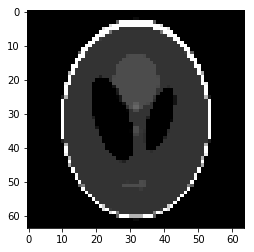

In [3]:
N = 64# reduce this if code is too slow N = 64 originally
image = imread(data_dir + "/phantom.png", as_grey=True)
image = rescale(image, (N / image.shape[0], N / image.shape[1]))
plt.imshow(image, interpolation='None')
plt.gray()

## Radon transform on circles

The Radon transform of a 2D image $f : \mathbb{R}^2 \to \mathbb{R}$ is defined as a collection of integrals along circles

$$
    [\mathcal{R} f](c,r) = \int_\ell f(x,y)\delta\left(\sqrt{(x-c)^2 + y^2} - r\right) dxdy
$$


## Forward operator

Before, we can begin, it is perhaps helpful, to build a graph (dict, here) marking correspondences between the parametric (c,r) co-ordinates and (x,y) co-ordinates so that they can be used later without messy square root calculations. To do this, we have the `build_hashmap` function. Here, we store the aforementioned dictionary along with the arc-length (`cut_length`) the pixel cuts from the circle. This arc-length has been approximated here, so feel free to improve on the algorithm. If you do so, let me know explicitly in the report and mark the same here.

Once we have the dictionaries (or hash-maps), we want to build a basis transformation matrix that would later take an image and give us its radon transform (on circles). To do so, we will use the cannonical basis and find its transform under the forward operator. I want you to implement this and for the same, it is easy to just use the hashmap.

All over the code, I assume one pixel length to be my unit of distance.

### Caution
 
I have tried my best to keep the code bug-free. If you notice a bug, please feel free to change the code. 

In [4]:
def build_hashmap(grid):
    """Input 
    :param grid: N x N x 2
    
    Returns
    --------
    hashmap_cr: dict with (c,r) keys that give a list of intersecting (x,y) points
                along with their cut-lengths
    hashmap_xy: dict with (x,y) keys that give a list of intersecting (c,r) points
                along with their cut-lengths
                
    hashmap has following format:
    {(c/x, r/y): (x/c, y/r, cut_length)}
    
    Logic
    ------
    I use the four corners of a pixel and check the center's distance with each of the
    four corners. If the radius, r is within the [`min_dist`, `max_dist`] range of the
    pixel corner distances, I will proceed to calcuate the cut length.
    
    To calculate the cut length, I fit a quadratic w.r.t distance from center
    whose roots are `min_dist` and `max_dist` and max value is sqrt(2). Then, just 
    using r in this quadratic, I get a cut-length.
    
    !! This is approximate cut-length, see if you can improve the algorithm. Although,
    I am not sure, an improvement is required (at least for now!)
    
    Note
    -----
    [1] cut_lengths are defined as the arc-length of the circle cutting the pixel
    [2] intersection of (c,r) with (x,y) implies that a circle with center ((c+0.5), 0)
        and radius, r passes through the pixel (x,y) (using 0 based indexing)
        
    """
    from collections import defaultdict # to avoid try blocks
    
    N,_,_ = grid.shape
    cgrid = np.arange(N)
    rgrid = np.arange(1,int(N*1.414+1)) #radius max is sqrt(2)*N, min 1
    g = np.array([grid[:,:,0]+1, grid[:,:,1]])
    
    # get the four corners
    c0 = grid.copy() # deep copy required
    
    c1 = c0.copy()
    c1[:,:,0] += 1
    
    c2 = c0.copy()
    c1[:,:,1] += 1
    
    c3 = c0.copy()
    c3[:,:,0] += 1
    c3[:,:,1] += 1
    
    # used 4x required space here for this 
    # concise and readable code here!!
    # Change if space-constrained 
    # (not the code; I mean your system :P)
    
    corners = np.stack((c0, c1, c2, c3))
    
    hashmap_cr = defaultdict(list) #cr to xy
    hashmap_xy = defaultdict(list) #xy to cr
    
    # kept loop for ease of understanding
    # feel free to remove and broadcast things!
    for c in cgrid:
        for r in rgrid:
            center = np.array([[(c+1)/2.0, 0]])
            d2corners =  np.linalg.norm(corners - center, axis = -1)
            min_d2corners = np.min(d2corners, axis=0)
            max_d2corners = np.max(d2corners, axis=0)
            
            pixels = list(zip(*np.where(np.logical_and(r>min_d2corners, r<max_d2corners))))
    
            if len(pixels)>1:
                for tup in pixels:
                    x1, y1 = tup
                    # take distances along four corners
                    # assume that the cut length decreases quadratically
                    # from the diagonal cut towards the far end 
                    # and near end corner (where the cut length is zero)
                    maxd, mind = max_d2corners[x1,y1], min_d2corners[x1,y1]

                    # fit a concave quadratic to this and find radius based cut
                    
                    # scale so that sqrt(2) is the max cut_length possible
                    # this is approximate, feel free to improve
                    # for eg. notice that this approximation breaks down
                    # when pixel is right above the (c,0) pixel
                    
                    cut_length = 4*1.414*(r-mind)*(maxd-r)/(maxd-mind)**2
                    
                    hashmap_cr[(c,r)].append((x1,y1,cut_length))
                    hashmap_xy[(x1,y1)].append((c,r,cut_length))
                        
    return hashmap_cr, hashmap_xy

In [5]:
def build(n):
    """Builds a grid + hashmap from the grid
    :param n: grid size (reduce this if too slow)
    
    Grid is not required, hence not returned.
    This is used solely for hashmap building purposes.
    
    Returns
    -------
    the hashmaps
    """
    a = np.arange(n)
    grid = np.array(np.meshgrid(a,a))
    grid= np.swapaxes(grid, 0, 2)
    grid= np.swapaxes(grid, 0, 1)
    return build_hashmap(grid)

cr2xy, xy2cr = build(N)

In [6]:
nr = int(N*1.414) # radius can go upto sqrt(2)*N

def forward_op(xy2cr, n=[N,nr]):
    """Builds basis vectors in (c,r) using basis vectors in (x,y)
    
    :param xy2cr: hashmap that given (x,y) pixel gives all the (c,r)
                that need updating with cut_length values given as 
                the third entry of the tuple
                n: grid data containing xy and cr area, for the transform n=[N,nr]
                
    Returns:
    -------
    mat: the matrix operator associated with the input grid n(N,nr) and the dict xy2cr
    """
    mat = np.zeros([n[0]*n[1],n[0]**2])#transform from N*N to N*R
    for x in range(n[0]):
      for y in range(n[1]):
          for tup in xy2cr[(x,y)]:
             mat[n[1]*tup[0]+tup[1]-1,n[0]*x+y]=1 #coordinate remap using dict xy2cr
    return mat

## Lights, circles, action!

Apply the transform to the image `image`.

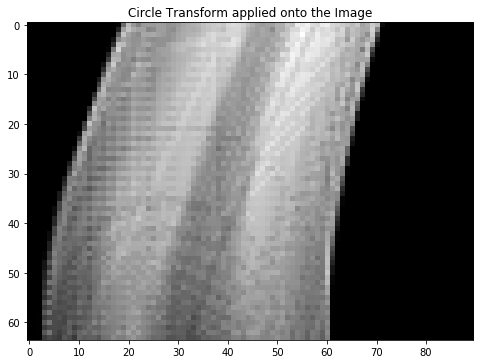

In [7]:
# image_cr = <result_from_forward_op> @ image.flatten()
mat = forward_op(xy2cr, n=[N,nr])
image_cr = (mat  @ image.flatten()).reshape(N, nr)
fig = plt.figure(figsize=(8, 14))
plt.title('Circle Transform applied onto the Image')
plt.imshow(image_cr, interpolation='None')

### Find the adjoint operator (here, transpose)

In [8]:
#ecr_adj = <get-adj-op>
ecr_adj = mat.T

### Find the inverse operator (here, pseudoinverse)

In [10]:
#ecr_pinv = <get-inverse-op>
ecr_pinv = np.linalg.pinv(mat)

### Check and report the reconstruction error

Apply the inverse and adjoint operator from the previous cell, and check the error w.r.t. original image.


error_pinv= 1.747448860032296e-11
error_adj= 48575.333405672405


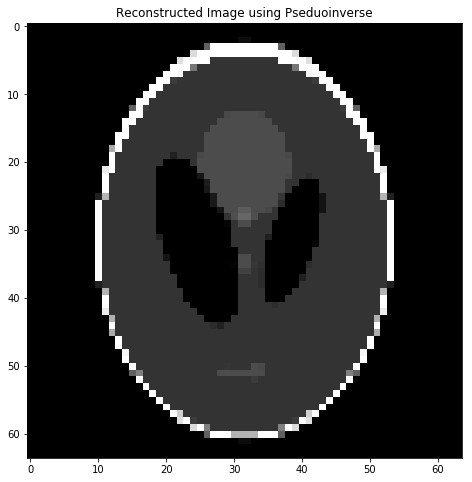

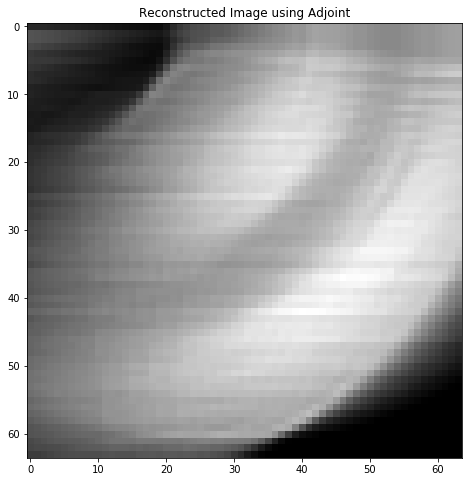

In [13]:
# reconstruction = <\result_from_pseduoinverse> @ image_cr
rec_pinv = (ecr_pinv @ image_cr.flatten()).reshape(N,N)
fig = plt.figure(figsize=(8, 8))
plt.title('Reconstructed Image using Pseduoinverse')
plt.imshow(rec_pinv, interpolation='None')
# get error of reconstruction
error_pinv = np.linalg.norm((rec_pinv-image),axis=(0,1))
print('error_pinv=',error_pinv)
# reconstruction = <\result_from_transpose> @ image_cr
rec_adj = np.dot(ecr_adj ,image_cr.flatten()).reshape(N,N)
fig = plt.figure(figsize=(8, 8))
plt.title('Reconstructed Image using Adjoint')
plt.imshow(rec_adj, interpolation='None')
# get error of reconstruction
error_adj = np.linalg.norm((rec_adj-image),axis=(0,1))
print('error_adj=',error_adj)

# PS 2 (MP2): X-ray diffraction

### Scattering potential function

You are given a 3D-grid with a certain occupancy `occ` function that has been struck with some EM waves at an angle initial $\psi_0$ and $\phi_0$. Your task is to find the scattering function $A(\phi, \psi)$ as defined in Blahut's textbook. Plot the magnitude of the received signal, $\nu(\phi, \psi)=\lambda^3 A(\phi, \psi)$.  

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from scipy.fftpack import fftn
from scipy.interpolate import griddata

N = 20 # number of grid points
M = 4 # space (MxMxM) an atom occupies
K = 3 # number of atoms
sigma = 1 # std-deviation

a = np.linspace(0,1,N) 

# original grid 
# || Note: you will need to figure out the
# frequencies at which we have our fftn

grid = np.stack(np.meshgrid(a,a,a), axis=3)

# occupancy grid
occ = np.zeros((N, N, N))

# atoms are modelled as Gaussians
atom = np.zeros((M, M, M))

atom[M//2, M//2, M//2] = 1
atom = gaussian(atom, sigma)

x = np.random.rand(3, K) / 2 + .25

for k in range(K):
    # introduce 3 atoms
    occ[int(x[0,k]*N)-M//2:int(x[0,k]*N)+M//2,
         int(x[1,k]*N)-M//2:int(x[1,k]*N)+M//2,
         int(x[2,k]*N)-M//2:int(x[2,k]*N)+M//2] += atom
    
# sample points on Ewald's sphere
n_points = 100 # 100 points on sphere
lam = 0.1 # wavelength of rays

psi = np.linspace(0.0, 2*np.pi, n_points)
phi = np.linspace(0.0, 2*np.pi, n_points)

# generate a grid of (psi, phi)
psi, phi = np.array(np.meshgrid(psi,phi))

# vectorize the same to have (n_points*n_points,) array
# instead of (n_points, n_points) array
psi = psi.flatten()
phi = phi.flatten()


# use these to simplify fx, fy, fz calculations
psi0 = 0
phi0 = 0
# for this grid, get the corresponding points on Ewald's sphere
# note that you need not use np.fft.fftshifts here. You know the 
# FFT is over uniform samples. You just need to add a shift in all 
# components such that the fft of `occ` and required frequencies 
# are in the same range.    

Text(0.5,1,'Signal Magnitudes ')

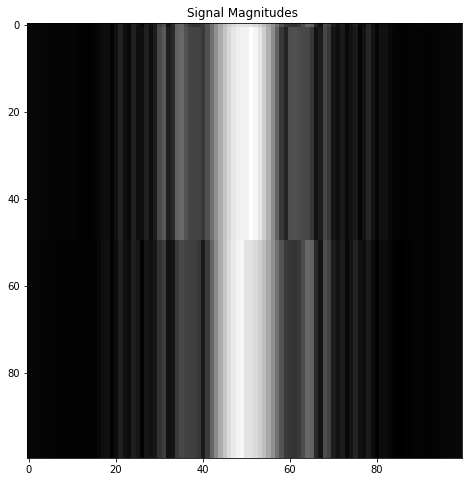

In [15]:
### Your code goes here

# for this grid, get the corresponding points on Ewald's sphere
fx = (np.cos(psi)*np.sin(phi)-np.cos(psi0)*np.sin(phi0))/lam-(np.cos(psi)*np.sin(phi))>0 
fy = (np.sin(psi)*np.sin(phi)-np.sin(psi0)*np.sin(phi0))/lam-(np.sin(psi)*np.sin(phi))>0 
fz = (np.cos(psi)-np.cos(psi0))/lam-2*(np.cos(psi)>0) 

# Get the fft on <fx, fy, fz>. To do this you will use the fft
# of the original `occ` (occupancy) and then interpolate
fft_occ = fftn(occ)
occ_vals = np.stack((fx,fy,fz), axis=1).reshape((-1,3))

freq1 = np.fft.fftfreq(N,d=0.05)
freq2 = np.fft.fftfreq(N,d=0.025)

freqx, freqy, freqz = np.array(np.meshgrid(freq1,freq1,freq2)) #spherical coord resampling
freqx = freqx.flatten()
freqy = freqy.flatten()
freqz = freqz.flatten()
orig_freq = np.stack((freqx,freqy,freqz), axis=1).reshape((-1,3))
occ_out = griddata(orig_freq, fft_occ.flatten(), occ_vals, method='linear')

# Plot scattering potential and received signal magnitudes 
# in a 2D plot w.r.t \phi and \psi
# You can make a 2D plot on a sphere too if needed.

# Include your plots in the report.

s_pot = occ_out.reshape(100,100)
s_pot_mag = lam**3*np.absolute(s_pot)
s_pot_mag_rec = np.zeros([100,100])
s_pot_mag_rec[:,0:50] = s_pot_mag[:,50:100]
s_pot_mag_rec[:,50:100] = s_pot_mag[:,0:50]

fig = plt.figure(figsize=(8, 8))
plt.imshow(s_pot_mag_rec)
plt.title('Signal Magnitudes ')

# Problem 2.6-Bonus
## Hexagonal crystal lattice

Consider the ideal infinite helix with b = $\lambda/2$ and a = $\lambda$. Sketch the scattering function $A(\phi, \psi)$ for the helix illuminated along the longitudinal axis.

Text(0.5,1,'Signal Magnitudes for Helix Illumination along the Longitudinal Axis')

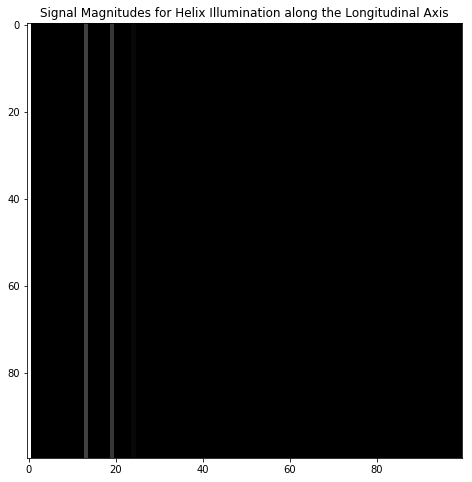

In [16]:
from scipy.special import jv
b = lam/2
a = lam
psi = np.linspace(0.0, 2*np.pi, n_points)
phi = np.linspace(0.0, 2*np.pi, n_points)
helix = np.zeros([n_points,n_points])

A1 = np.zeros([4,]) 
psi1 = np.zeros([4,])
for i in range(4):
    psivalue = 1-i/np.pi
    psi1[i] = np.arccos(psivalue)
    A1[i] = jv(i,2*np.pi*np.sin(psi1[i]))
    
helix[:,0] = A1[0]
helix[:,13] = A1[1]
helix[:,19] = A1[2]
helix[:,24] = A1[3]

fig = plt.figure(figsize=(8, 8))
plt.imshow(np.absolute(helix))
plt.title('Signal Magnitudes for Helix Illumination along the Longitudinal Axis')

## Thermal noise

Thermal energy causes molecules to randomly vibrate and thus imperfections in the spacing and orientation.In essence, it's the broadening of the grating main lobe.  

Text(0.5,1,'Signal Magnitudes under Thermal Noise')

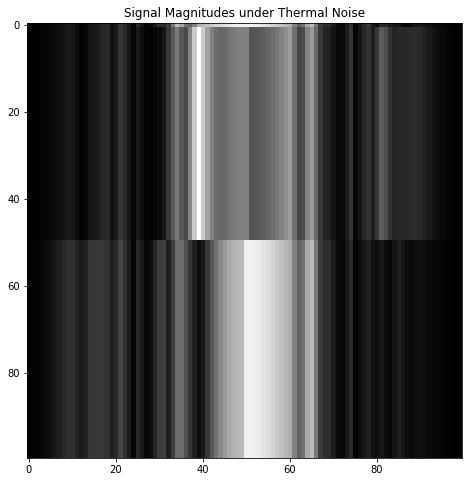

In [17]:
N = 20 # number of grid points
M = 4 # space (MxMxM) an atom occupies
K = 3 # number of atoms
sigma = 10000 # std-deviation

a = np.linspace(0,1,N) 

# original grid 
# || Note: you will need to figure out the
# frequencies at which we have our fftn

grid = np.stack(np.meshgrid(a,a,a), axis=3)

# occupancy grid
occ = np.zeros((N, N, N))

# atoms are modelled as Gaussians
atom = np.zeros((M, M, M))

atom[M//2, M//2, M//2] = 1
atom = gaussian(atom, sigma)

x = np.random.rand(3, K) / 2 + .25

for k in range(K):
    # introduce 3 atoms
    occ[int(x[0,k]*N)-M//2:int(x[0,k]*N)+M//2,
         int(x[1,k]*N)-M//2:int(x[1,k]*N)+M//2,
         int(x[2,k]*N)-M//2:int(x[2,k]*N)+M//2] += atom
    
    
### Your code goes here

# sample points on Ewald's sphere
n_points = 100 # 100 points on sphere
lam = 0.1 # wavelength of rays

psi = np.linspace(0.0, 2*np.pi, n_points)
phi = np.linspace(0.0, 2*np.pi, n_points)
# generate a grid of (psi, phi)
psi, phi = np.array(np.meshgrid(psi,phi))

# vectorize the same to have (n_points*n_points,) array
# instead of (n_points, n_points) array
psi = psi.flatten()
phi = phi.flatten()


# use these to simplify fx, fy, fz calculations
psi0 = 0
phi0 = 0
# for this grid, get the corresponding points on Ewald's sphere
# note that you need not use np.fft.fftshifts here. You know the 
# FFT is over uniform samples. You just need to add a shift in all 
# components such that the fft of `occ` and required frequencies 
# are in the same range.

fx = (np.cos(psi)*np.sin(phi)-np.cos(psi0)*np.sin(phi0))/lam-(np.cos(psi)*np.sin(phi))>0 
fy = (np.sin(psi)*np.sin(phi)-np.sin(psi0)*np.sin(phi0))/lam-(np.sin(psi)*np.sin(phi))>0 
fz = (np.cos(psi)-np.cos(psi0))/lam-2*(np.cos(psi)>0) 


# Get the fft on <fx, fy, fz>. To do this you will use the fft
# of the original `occ` (occupancy) and then interpolate
# You need to calculate the grid of frequencies you have when you do
# fft on the 'grid' defined earlier. You will use that in your griddata
# function and interpolate on np.stack((fx,fy,fz), axis=1).reshape((-1,3))

fft_occ = fftn(occ)
occ_vals = np.stack((fx,fy,fz), axis=1).reshape((-1,3))

freq1 = np.fft.fftfreq(N,d=0.05)
freq2 = np.fft.fftfreq(N,d=0.025)

freqx, freqy, freqz = np.array(np.meshgrid(freq1,freq1,freq2)) #spherical coord resampling
freqx = freqx.flatten()
freqy = freqy.flatten()
freqz = freqz.flatten()
orig_freq = np.stack((freqx,freqy,freqz), axis=1).reshape((-1,3))
occ_out = griddata(orig_freq, fft_occ.flatten(), occ_vals, method='linear')
 


# Plot scattering potential and received signal magnitudes 
# in a 2D plot w.r.t \phi and \psi

# plt.imshow(<reshaped output>)

# You can make a 2D plot on a sphere too if needed.

# Include your plots in the report.

s_pot = occ_out.reshape(100,100)
s_pot_mag = lam**3*np.absolute(s_pot)
s_pot_mag_rec = np.zeros([100,100])
s_pot_mag_rec[:,0:50] = s_pot_mag[:,50:100]
s_pot_mag_rec[:,50:100] = s_pot_mag[:,0:50]

fig = plt.figure(figsize=(8, 8))
plt.imshow(s_pot_mag_rec)
plt.title('Signal Magnitudes under Thermal Noise')